# Проект для «Викишоп»

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

import nltk
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords

nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from nltk.corpus import stopwords 
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

import spacy
from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer 
import nltk
nltk.download('wordnet')
from tqdm import tqdm
tqdm.pandas()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [4]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [5]:
data.query('toxic == 1')

,Unnamed: 0,text,toxic
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
12,12,Hey... what is it..\n@ | talk .\nWhat is it......,1
16,16,"Bye! \n\nDon't look, come or think of comming ...",1
42,42,You are gay or antisemmitian? \n\nArchangel WH...,1
43,43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1
...,...,...,...
159215,159374,"""\n\n our previous conversation \n\nyou fuckin...",1
159235,159394,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159262,159421,Your absurd edits \n\nYour absurd edits on gre...,1
159267,159426,"""\n\nHey listen don't you ever!!!! Delete my e...",1


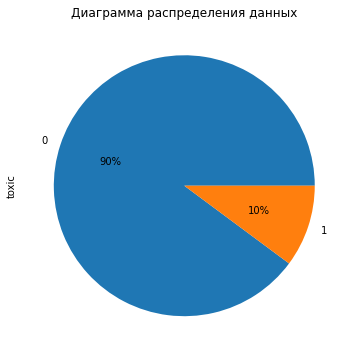

In [6]:
plt.figure(figsize=(10, 6))
data['toxic'].value_counts().plot(kind='pie', autopct = '%1.0f%%')
plt.title('Диаграмма распределения данных');

Загрузили данные, выяснили, что в них присутствует 10% токсичных данных (16186 шт).

приведем все данные к нижнему регистру

In [7]:
data.text = data.text.str.lower()

In [8]:
# data = data.rename(columns={'Unnamed: 0': 'unnamed'})    

In [9]:
### Вернулся назад и подумал, что столбец Unnamed: 0 нам не нужен, предлагаю его удалить

In [10]:
data = data.drop(['Unnamed: 0'], axis=1)

In [11]:
data.tail(3)

,text,toxic
159289,"spitzer \n\numm, theres no actual article for ...",0
159290,and it looks like it was actually you who put ...,0
159291,"""\nand ... i really don't think you understand...",0


уберем пунктуацию, произведем замены и приведем текст в нижний регистр

In [12]:
def remove_odd(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)

    text = text.split()
    text = " ".join(text)

    return text
data['odds_free'] = data['text'].apply(lambda x: remove_odd(x.lower()))
display(data.head())

,text,toxic,odds_free
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...


удалим стоп слова

In [13]:
stop_words = set(nltk_stopwords.words('english'))

def remove_stopwords(text):
    text_ready = [i for i in text.split() if not i in stop_words]
    return text_ready

data['stopwords_free'] = data['odds_free'].apply(lambda x: remove_stopwords(x))
display(data.head())

,text,toxic,odds_free,stopwords_free
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, edits, made, username, hardcore,..."
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,"[aww, matches, background, colour, seemingly, ..."
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,"[hey, man, really, trying, edit, war, guy, con..."
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,"[make, real, suggestions, improvement, wondere..."
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]"


определение тега POS

In [14]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

выполним лемматизацию

In [15]:
%%time
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(x, get_wordnet_pos(x)) for x in nltk.word_tokenize(text)])
    return lemmatized_text

data['lemmatized'] = data['odds_free'].progress_apply(lambda x: lemmatize_text(x))
display(data.head())

100%|██████████| 159292/159292 [21:20<00:00, 124.36it/s]


,text,toxic,odds_free,stopwords_free,lemmatized
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, edits, made, username, hardcore,...",explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he matches this background colour i m se...,"[aww, matches, background, colour, seemingly, ...",d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not trying to edit war it s...,"[hey, man, really, trying, edit, war, guy, con...",hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,"[make, real, suggestions, improvement, wondere...",more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,"[sir, hero, chance, remember, page]",you sir be my hero any chance you remember wha...


CPU times: user 19min 25s, sys: 1min 36s, total: 21min 2s
Wall time: 21min 20s


Подготовили данные для дальнейшей работы:
* привели к нижнему регистру;
* Лемматизировали;
* токенизировали;
* убрали лишние символы и признаки.

## Обучение

разобьем на обучающую и тестовую выборки

In [16]:
df = data[['toxic', 'lemmatized']]
y = df['toxic']
X = df.drop(['toxic'], axis=1)

In [17]:
RANDOM_STATE = 42

In [18]:
X_train, X_test, y_train, y_test = (
                        train_test_split(X,
                                         y,
                                         test_size=0.25,
                                         random_state=RANDOM_STATE))

In [19]:
display(f'Размер X_train = {X_train.shape}')
display(f'Размер X_test = {X_test.shape}')
display(f'Размер y_train = {y_train.shape}')
display(f'Размер y_test = {y_test.shape}')

'Размер X_train = (119469, 1)'

'Размер X_test = (39823, 1)'

'Размер y_train = (119469,)'

'Размер y_test = (39823,)'

In [20]:
X_train

,lemmatized
17183,the source be also not acceptable for reason a...
123920,etaonash just like the rest of the editor you ...
12358,do you remove my post on the discussion page f...
101443,aggressive edit please discus with me any diss...
29758,really good contributor bullshit the cabal dis...
...,...
119879,first of all editor theredpenofdoom be not a m...
103694,and decide to become gay
131932,john bull v adolf hitler look at the picture o...
146867,october you have a lot to learn about the way ...


### Модель линейной регрессии

In [21]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(X_train['lemmatized'], y_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [ ]:
%%time
lr_mod = training(LogisticRegression(), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7833064819072815
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}
CPU times: user 5min 49s, sys: 4min 45s, total: 10min 35s
Wall time: 10min 35s

### Модель дерево решений

In [23]:
%%time
dtc_mod = training(DecisionTreeClassifier(), {'model__criterion':['gini','entropy'],'model__max_depth':[2,4,6]})

Лучший результат: 0.5635713873418473
Лучшие параметры: {'model__criterion': 'gini', 'model__max_depth': 6}
CPU times: user 4min 35s, sys: 1.52 s, total: 4min 37s
Wall time: 4min 37s


### Модель CatBoost

In [24]:
#%%time
#cat_mod = training(CatBoostClassifier(logging_level='Silent'), {'model__depth': [4,6],
#                 'model__learning_rate' : [0.01,0.03],
#                  'model__iterations' : [10, 50]})

Лучший результат у можели линейной регрессии, проверим на тестовой выборке

In [25]:
f1 = f1_score(y_test, lr_mod.predict(X_test['lemmatized']))

In [26]:
print(f'Результат LogisticRegression {round(f1,2)}')

Результат LogisticRegression 0.79


## Выводы

Лучше всего справилась модель линейной регрессии с метрикой F1 на тренировочной выборке 0,78 и на тестовой 0,79